# Tutorial on ProfileHistogram

In [1]:
from matplotlib import pyplot as plt
import poisson_approval as pa

## Profile

Generate a random profile:

In [2]:
generator_profile = pa.GeneratorProfileHistogramUniform(n_bins = 10)
profile = generator_profile()
profile

<abc: 0.014093683812545721 [0.12902165 0.13038141 0.25386721 0.06899872 0.16094093 0.03105416
 0.00436686 0.10496423 0.03151964 0.0848852 ], acb: 0.3556191653985178 [0.22578093 0.08992128 0.00935606 0.23376057 0.10210256 0.06074381
 0.11135558 0.12683691 0.01338817 0.02675412], bac: 0.09120516299879933 [0.22223229 0.01154818 0.19434652 0.17189083 0.2592756  0.01385795
 0.0068147  0.03255832 0.07861565 0.00885997], bca: 0.18985105472032138 [0.0139795  0.04927313 0.03575703 0.03517683 0.290629   0.14129978
 0.15652724 0.03980198 0.11906643 0.11848907], cab: 0.1966167402725948 [0.04973717 0.02364423 0.07491768 0.10821358 0.03714189 0.09180188
 0.20862091 0.053674   0.00449641 0.34775227], cba: 0.152614192797221 [0.07244281 0.08510434 0.19292881 0.03326211 0.03228866 0.23185513
 0.06160289 0.12650861 0.14374293 0.0202637 ]> (Condorcet winner: c)

Share of each ranking:

In [3]:
profile.d_ranking_share

{abc: 0.014093683812545721, acb: 0.3556191653985178, bac: 0.09120516299879933, bca: 0.18985105472032138, cab: 0.1966167402725948, cba: 0.152614192797221}

Distribution of the utilities for voters $abc$:

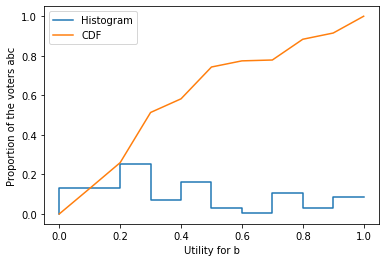

In [4]:
ranking = 'abc'
profile.plot_histogram(ranking, label='Histogram')
profile.plot_cdf(ranking, label='CDF')
plt.ylabel('Proportion of the voters %s' % ranking)
plt.legend()

## Strategic Analysis

Generate a random strategy:

In [5]:
generator_strategy = pa.GeneratorStrategyThresholdUniform()
strategy = generator_strategy()
strategy

<abc: utility-dependent (0.894157491702005), acb: utility-dependent (0.985992744194446), bac: utility-dependent (0.7621812886787621), bca: utility-dependent (0.15397289700739614), cab: utility-dependent (0.32639579468120816), cba: utility-dependent (0.7737421645782198)>

Tau vector (ballot shares) associated to the strategy in the given profile:

In [6]:
tau = profile.tau(strategy)
tau

<a: 0.3671578605482438, ab: 0.010323548454573821, ac: 0.16317522182029354, b: 0.08980686136337036, bc: 0.21224744885590724, c: 0.15728905895761125> ==> a

Is the strategy an equilibrium for the given profile?

In [7]:
profile.is_equilibrium(strategy)

EquilibriumStatus.NOT_EQUILIBRIUM

Use iterated voting to search for an equilibrium:

In [8]:
result = profile.iterated_voting(strategy_ini=strategy, n_max_episodes=1000, 
                                 ballot_update_ratio=0.1)
cycle_taus_actual = result['cycle_taus_actual']
cycle_strategies = result['cycle_strategies']

In [9]:
cycle_taus_actual

[<a: 0.3622605056056952, ab: 0.09865750660416805, bc: 0.23099043015712836, c: 0.30809155763300883> ==> c]

In [10]:
if len(cycle_taus_actual) == 0:
    print('No convergence.')
elif len(cycle_taus_actual) == 1:
    print('Convergence to an equilibrium.')
    print('Limit strategy: %s' % cycle_strategies[0])
    print('Limit tau-vector: %s' % cycle_taus_actual[0])
else:
    print('Convergence to a cycle of cardinality %s.' % len(cycle_taus_actual))

Convergence to an equilibrium.
Limit strategy: <abc: utility-dependent (0.2834393168410417), acb: a, bac: ab, bca: bc, cab: c, cba: utility-dependent (0.7165606831589585)> ==> c
Limit tau-vector: <a: 0.3622605056056952, ab: 0.09865750660416805, bc: 0.23099043015712836, c: 0.30809155763300883> ==> c


There is another version of iterated voting, ``fictitious_play``. It allows for update ratios that depend on time, it is faster, but it is not able to detect limit cycles (only convergence). Cf. Reference section for more information.

In [11]:
from math import log
result = profile.fictitious_play(strategy_ini=strategy, n_max_episodes=1000, 
                                 perception_update_ratio=lambda t: 1 / log(t + 2),
                                 ballot_update_ratio=0.1)
limit_tau = result['tau']
limit_strategy = result['strategy']

In [12]:
if limit_tau is None:
    print('No convergence.')
else:
    print('Convergence to an equilibrium.')
    print('Limit strategy: %s' % limit_strategy)
    print('Limit tau-vector: %s' % limit_tau)

Convergence to an equilibrium.
Limit strategy: <abc: utility-dependent (0.2834393159072892), acb: a, bac: ab, bca: bc, cab: c, cba: utility-dependent (0.7165606840927107)> ==> c
Limit tau-vector: <a: 0.36226050557228584, ab: 0.098657506637577, bc: 0.2309904299768487, c: 0.30809155781328845> ==> c


The methods ``iterated_voting`` and ``fictitious_play`` also provide the winning frequency of each candidate. In case of convergence to a limit or a periodical orbit, these frequencies are computed at the limit. In case of non-convergence, it gives the winning frequencies on the history of the process.

In [13]:
result = profile.iterated_voting(strategy_ini=strategy, n_max_episodes=10, 
                                 ballot_update_ratio=0.1)
result['d_candidate_winning_frequency']

{a: 1/11, c: 10/11}